# Deteccion de fraude en tarjetas de credito con redes neuronales

## Imports

In [170]:
import sys;
assert sys.version_info >= (3, 5);
import sklearn;
assert sklearn.__version__ >= "0.20";
import numpy as np;
import math;
import os;
import matplotlib as mpl;
import matplotlib.pyplot as plt;
import pandas as pd;
import seaborn as sns;
from scipy import stats;
from scipy.stats import norm;
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

## Carga de datos

In [171]:
# dataset from https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
df = pd.read_csv(filepath_or_buffer="dataset/creditcard_sin_outliers.csv")
df = df.drop(columns=['Unnamed: 0'])
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Borrar lo sobrante

In [172]:
df = df.drop(['Time'], axis=1)
df = df.drop(['Amount'], axis=1)

## Generacion de datos para aumentar la cantidad de positivos

In [173]:
of_dataset = '% of the dataset'
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), of_dataset)
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), of_dataset)

No Frauds 99.78 % of the dataset
Frauds 0.22 % of the dataset


Como hay muy pocos datos de fraude, se generan datos sinteticos para aumentar la cantidad de positivos
y mejorar el entrenamiento de la red neuronal.

In [206]:
fraudes = df[df['Class'] == 1].copy()
no_fraudes = df[df['Class'] == 0].copy()

no_fraudes = sklearn.utils.shuffle(no_fraudes)
no_fraudes = no_fraudes.sample(len(fraudes)*10)
df2 = pd.concat([fraudes, no_fraudes], axis=0)
df2 = sklearn.utils.shuffle(df2)


In [207]:
print('No Frauds', round(df2['Class'].value_counts()[0]/len(df2) * 100,2), '% of the dataset')
print('Frauds', round(df2['Class'].value_counts()[1]/len(df2) * 100,2), '% of the dataset')

No Frauds 90.91 % of the dataset
Frauds 9.09 % of the dataset


In [208]:
df2.shape

(5412, 29)

## Separacion de datos de entrenamiento y test

In [209]:
# make x_train and y_train a 80% of the dataset and test 20%
x_train = df2.iloc[:int(len(df2)*0.8), :-1]
y_train = df2.iloc[:int(len(df2)*0.8), -1]
x_test = df2.iloc[int(len(df2)*0.8):, :-1]
y_test = df2.iloc[int(len(df2)*0.8):, -1]

## Creacion de la red neuronal

In [178]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation

model = Sequential()
model.add(Dense(28, activation='sigmoid', input_shape=(28,)))
model.add(Dense(10, activation='sigmoid', input_shape=(29,)))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 28)                812       
_________________________________________________________________
dense_29 (Dense)             (None, 10)                290       
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 11        
Total params: 1,113
Trainable params: 1,113
Non-trainable params: 0
_________________________________________________________________


## Entrenamiento

In [179]:
model.compile(loss="binary_crossentropy", optimizer="sgd",metrics = ['accuracy'])

In [183]:
model.fit(x_train, y_train, batch_size=50, epochs=50)

Epoch 1/50
4329/4329 [==============================] - 0s 22us/step - loss: 0.1468 - accuracy: 0.9492
Epoch 2/50
4329/4329 [==============================] - 0s 15us/step - loss: 0.1433 - accuracy: 0.9580
Epoch 3/50
4329/4329 [==============================] - 0s 14us/step - loss: 0.1400 - accuracy: 0.9630
Epoch 4/50
4329/4329 [==============================] - 0s 15us/step - loss: 0.1367 - accuracy: 0.9707
Epoch 5/50
4329/4329 [==============================] - 0s 15us/step - loss: 0.1336 - accuracy: 0.9739
Epoch 6/50
4329/4329 [==============================] - 0s 15us/step - loss: 0.1307 - accuracy: 0.9755
Epoch 7/50
4329/4329 [==============================] - 0s 15us/step - loss: 0.1279 - accuracy: 0.9762
Epoch 8/50
4329/4329 [==============================] - 0s 15us/step - loss: 0.1251 - accuracy: 0.9776
Epoch 9/50
4329/4329 [==============================] - 0s 14us/step - loss: 0.1226 - accuracy: 0.9781
Epoch 10/50
4329/4329 [==============================] - 0s 15us/step - l

In [210]:
test_loss, test_acc = model.evaluate(x_test, y_test)

1083/1083 [==============================] - 0s 19us/step


In [217]:
from sklearn.metrics import confusion_matrix
import numpy as np
predictions = model.predict(x_test)

Y_pred_classes = []
for pred in predictions:
    if pred > 0.5:
        Y_pred_classes.append(1)
    else:
        Y_pred_classes.append(0)
Y_pred_classes = np.array(Y_pred_classes)
Y_true = y_test.values 
print(Y_true)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
confusion_mtx

[0 1 0 ... 0 0 0]


array([[976,   1],
       [ 20,  86]], dtype=int64)

([<matplotlib.axis.YTick at 0x214deda0548>,
 [Text(0, 0, 'No Fraud'), Text(0, 1, 'Fraud')])

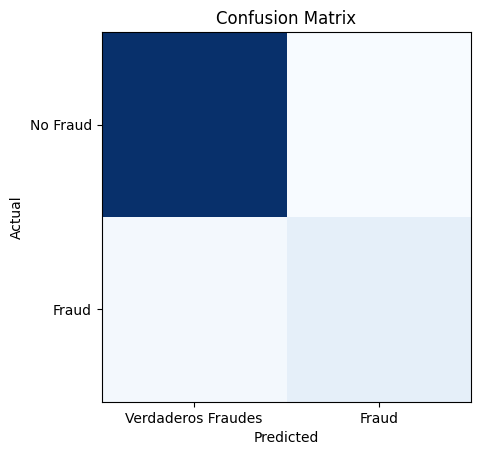

In [218]:
# plot the confusion matrix
plt.imshow(confusion_mtx, cmap='Blues' )
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0,1], ['Verdaderos Fraudes', 'Fraud'])
plt.yticks([0,1], ['No Fraud', 'Fraud'])